# Using segmentation data to label cells and plot nearest-neighbors

## Prerequisites

This notebook assumes that single-cell segmentation has already been performed, and shows some calculations and visualizations that can be done with segmented data in combination with the underlying MibiImages.

The data used here is downloadable from the IONpath Public MIBItracker. Sign-up or login to your free account at https://mibi-share.ionpath.com.

In [2]:
import io
import os
import requests

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from skimage import color, filters, io as skio, measure, segmentation as skseg
from sklearn.neighbors import KDTree

from mibidata.mibi_image import MibiImage
from mibidata import color as mibicolor, segmentation, tiff
from mibitracker.request_helpers import MibiRequests

%matplotlib notebook

matplotlib.rcParams.update({
    'font.size': 8,
    'axes.grid': False,
    'image.cmap': 'gray',
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get image and segmentation data from MIBItracker

In this example, we will use the tonsil image available from the IONpath Public MIBItracker at https://mibi-share.ionpath.com/tracker/overlay/sets/4/6.

In [3]:
# Email/password are saved as environment variables in this example.
mr = MibiRequests(
    'https://backend-dot-mibitracker-share.appspot.com',
    os.getenv('MIBITRACKER_PUBLIC_EMAIL'),
    os.getenv('MIBITRACKER_PUBLIC_PASSWORD')
)

IMAGE_ID = 17
image_info = mr.get('/images/{}/'.format(IMAGE_ID)).json()

A typical output of a segmentation pipeline is a _label image_, i.e. a map where each pixel is assigned an integer of either background (0) or a label unique to a particular cell. That information can be combined with the original MibiImage to quantify expression levels for all measured markers.

In [4]:
# Download the MIBItiff plus cell segmentation data directly from MIBItracker.
image = mr.get_mibi_image(IMAGE_ID)

cell_labels = mr.get_channel_data(IMAGE_ID, 'segmentation_labels')

In [5]:
# Helper function for per-channel visualization scaling.
def _scale(image_data):
    return np.power(image_data / image_data.max(axis=(0, 1)), 1/3)

<IPython.core.display.Javascript object>


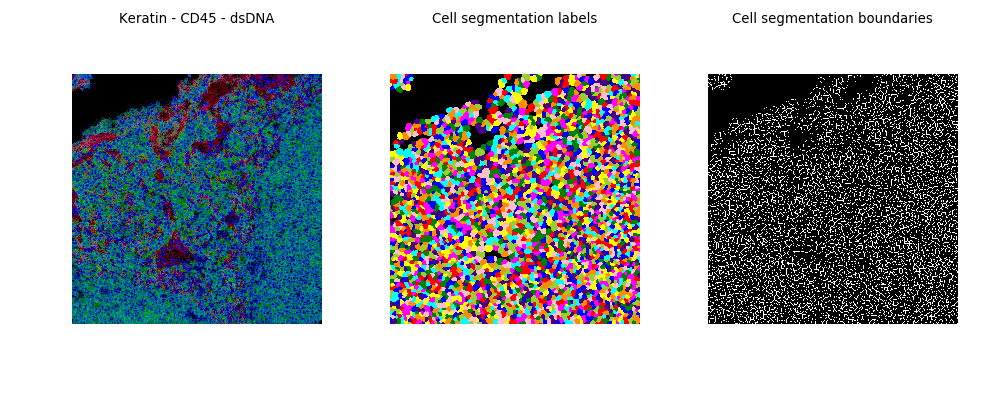

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(_scale(image[['Keratin', 'CD45', 'dsDNA']]))
ax[0].set_title('Keratin - CD45 - dsDNA')
# Randomly re-order labels to get better color constrast between neighboring cells.
ax[1].imshow(color.label2rgb(cell_labels, bg_label=0))
ax[1].set_title('Cell segmentation labels')
# Use label image to create boundaries
boundaries = skseg.find_boundaries(cell_labels, mode='outer')
ax[2].imshow(boundaries)
ax[2].set_title('Cell segmentation boundaries')
[a.axis('off') for a in ax]
fig.tight_layout()

## Calculate single-cell features

We are interested in single-cell expression levels, so a next step is often to integrate the counts for all channels in the image within each cell, and collection in a table. This will also include the coordinates of the centroid of each cell, and be indexed by the cell label so that these values can be mapped back to the image itself.

In [7]:
cell_sums = segmentation.extract_cell_dataframe(
    cell_labels, image, mode='total')
cell_sums.head()

,area,x_centroid,y_centroid,beta-tubulin,CD11c,CD3,CD31,CD4,CD45,CD56,CD68,CD8,dsDNA,FOXP3,"HLA class 1 A, B, and C",Keratin,Lamin A/C,Na-K-ATPase alpha1,PD-L1,Vimentin
label,,,,,,,,,,,,,,,,,,,,
2,83,65,3,133,7,3,0,0,159,0,3,0,2605,4,79,5,4,3,0,48
4,145,585,3,373,17,19,0,14,531,0,2,0,2463,1,479,87,4,71,2,34
5,123,616,3,166,5,0,2,0,117,0,24,1,1500,0,121,945,4,13,0,2
7,114,927,3,321,54,1,1,16,134,0,10,0,913,0,230,43,28,54,2,62
8,100,943,3,290,36,0,16,10,106,0,8,1,941,1,340,186,113,22,45,62


<IPython.core.display.Javascript object>


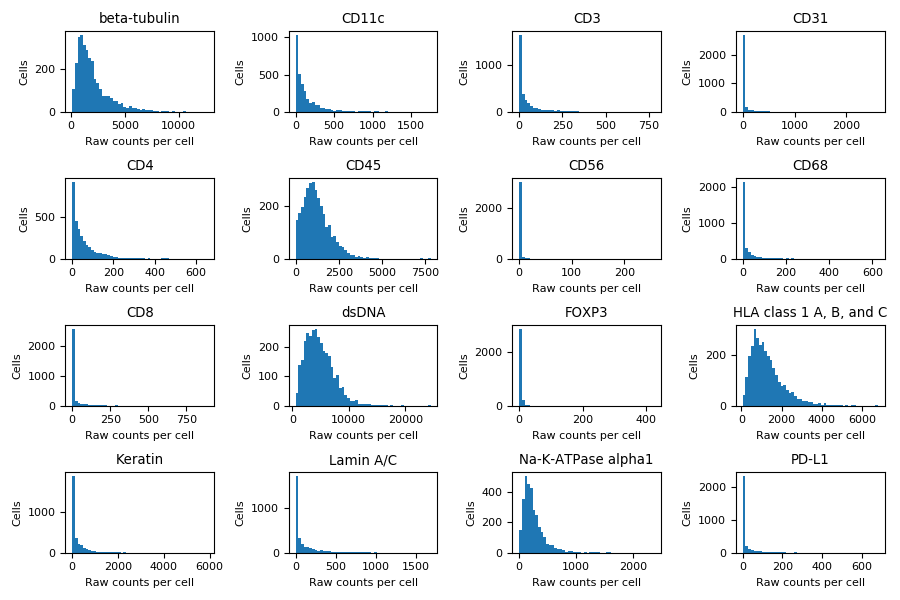

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(9, 6))
for a, channel in zip(ax.flat, image.targets):
    _ = a.hist(cell_sums[channel], bins=50)
    a.set_title(channel)
    a.set_xlabel('Raw counts per cell')
    a.set_ylabel('Cells')
fig.tight_layout()

One useful way to map back to the image is to replace the value of each pixel with the value of the cell's total on that channel. This helps to show how the numbers seen above correspond to whether a cell is truly "positive" for that marker.

<IPython.core.display.Javascript object>


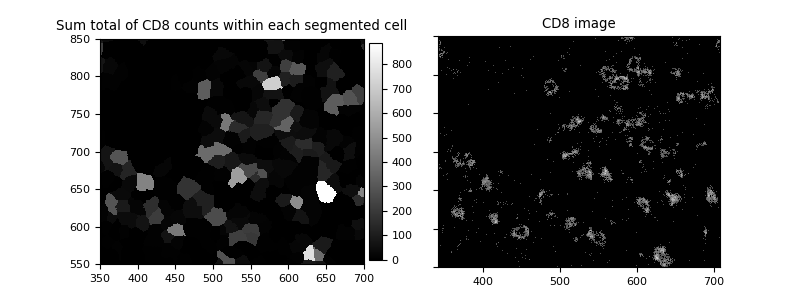

Text(0.5,1,'CD8 image')

In [9]:
cell_sum_image = segmentation.replace_labeled_pixels(cell_labels, cell_sums, list(image.targets))

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
cb = ax[0].imshow(cell_sum_image['CD8'])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cb, cax=cax)
ax[1].imshow(_scale(image['CD8']))
ax[0].set_xlim((350, 700))
ax[0].set_ylim((550, 850))
ax[0].set_title('Sum total of CD8 counts within each segmented cell')
ax[1].set_title('CD8 image')

Unsurprisingly, the CD8 counts aren't perfectly isolated within the segmentation regions of CD8 T cells, and thus cells _nearby_ to those will strong membrane staining will often be affected. Put another way, merely summing the counts within each labeled region does not leverage their spatial distribution _within_ the cell, which is a big part of the information we are using when visually interpreting whether a CD8 T cell is present.

To help with this, we can compute a cell score that is weighted by the distribution of counts from each channel around the cell. A simple way to do this is to take the geometric mean over quadrants of the cell.

<IPython.core.display.Javascript object>


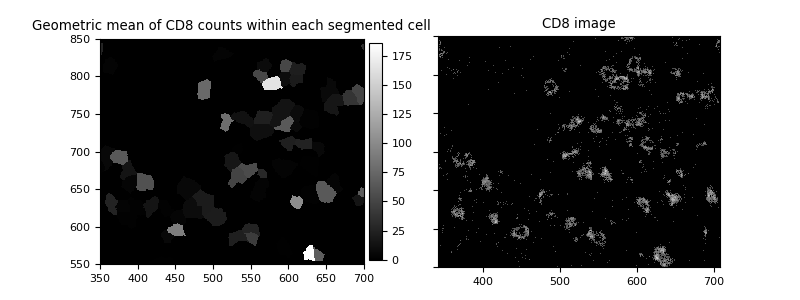

Text(0.5,1,'CD8 image')

In [10]:
cell_scores = segmentation.extract_cell_dataframe(
    cell_labels, image, mode='quadrant')
cell_scores_image = segmentation.replace_labeled_pixels(cell_labels, cell_scores, list(image.targets))

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
cb = ax[0].imshow(cell_scores_image['CD8'])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cb, cax=cax)
ax[1].imshow(_scale(image['CD8']))
ax[0].set_xlim((350, 700))
ax[0].set_ylim((550, 850))
ax[0].set_title('Geometric mean of CD8 counts within each segmented cell')
ax[1].set_title('CD8 image')

Notice how this compresses the range of values, but in particular has suppressed the contribution of small fractional areas with CD8 counts to their cell's total. To see it another way, we can compare bi-axial plots of CD8 vs. CD4 data and view the reduction in false double-positives.

<IPython.core.display.Javascript object>


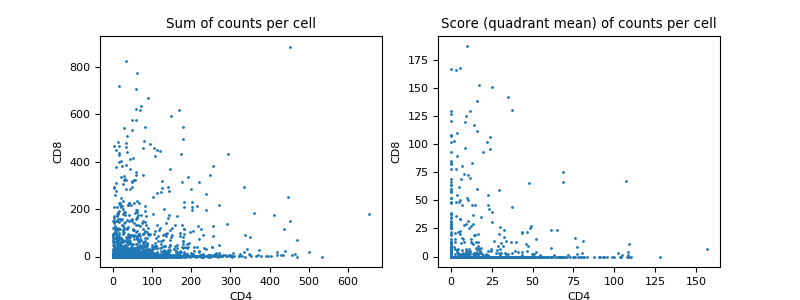

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(cell_sums[ 'CD4'], cell_sums['CD8'], '.', markersize=2)
ax[0].set_title('Sum of counts per cell')
ax[1].plot(cell_scores['CD4'], cell_scores['CD8'], '.', markersize=2)
ax[1].set_title('Score (quadrant mean) of counts per cell')
for a in ax:
    a.set_xlabel('CD4')
    a.set_ylabel('CD8')

This is just one example of an approach to combining spatial and pixel-level count information to calculate cellular features. There are numerous other options, and over time more will be added to this library! In the meantime, keep in mind that for many downstream analyses such as clustering or classification, one does not need to choose a single best way to represent the CD8 level in each cell, but rather can construct a feature vector containing both pure sums and weighted scores and use them together (among other metrics) to refine the outcome.

## Classify cells

Here we show simple thresholding of the cell score, and how to view those results relative to the initial image.

<IPython.core.display.Javascript object>


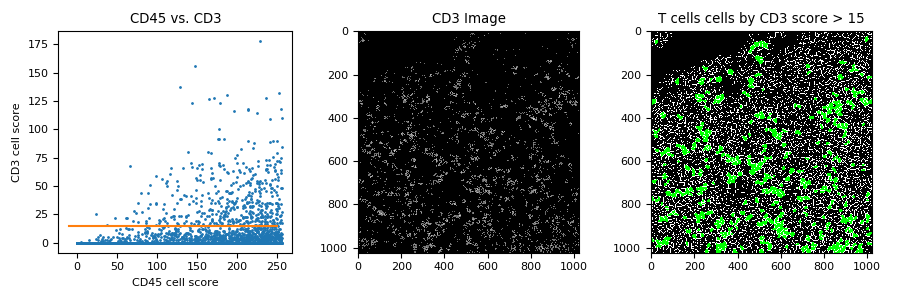

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].plot(cell_scores['CD45'], cell_scores['CD3'], '.', markersize=2)
ax[0].plot([-10, 250], [15, 15])
ax[0].set_xlabel('CD45 cell score')
ax[0].set_ylabel('CD3 cell score')
ax[0].set_title('CD45 vs. CD3')
ax[1].imshow(_scale(image['CD3']))
ax[1].set_title('CD3 Image')
cd3_positive = np.zeros((1024, 1024, 3), np.uint8)
cd3_positive[boundaries, :] = 255
cd3_positive[cell_scores_image['CD3'] > 15, 1] = 255
ax[2].imshow(cd3_positive)
ax[2].set_title('T cells cells by CD3 score > 15')
cd3_cells = cell_scores['CD3'] > 15

fig.tight_layout()

We can drill down further, in this case manually gating CD4 and CD8 T cell subsets.

<IPython.core.display.Javascript object>


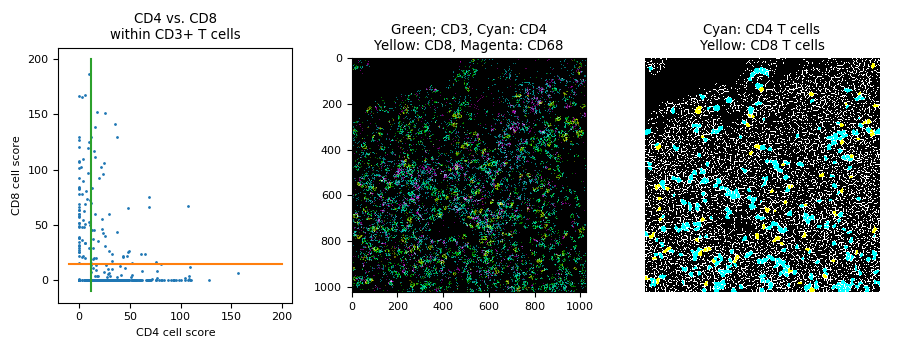

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))

ax[0].plot(cell_scores['CD4'][cd3_cells], cell_scores['CD8'][cd3_cells], '.', markersize=2)
ax[0].plot([-10, 200], [15, 15])
ax[0].plot([12, 12], [-10, 200])
ax[0].set_xlabel('CD4 cell score')
ax[0].set_ylabel('CD8 cell score')
ax[0].set_title('CD4 vs. CD8\n'
                'within CD3+ T cells')

color_map = {
    'Green': 'CD3',
    'Cyan': 'CD4',
    'Yellow': 'CD8',
    'Magenta': 'CD68'
}
screened = mibicolor.composite(image, color_map)
ax[1].imshow(screened)
ax[1].set_title('Green; CD3, Cyan: CD4\n'
                'Yellow: CD8, Magenta: CD68')

positive_cells = np.zeros((1024, 1024, 3), np.uint8)
positive_cells[boundaries, :] = 255
cd4_pos = ((cell_scores_image['CD3'] > 15) &
               (cell_scores_image['CD4'] > 15) &
               (cell_scores_image['CD8'] < 15))
positive_cells[cd4_pos, 1:] = 255
cd8_pos = ((cell_scores_image['CD3'] > 15) &
               (cell_scores_image['CD4'] < 15) &
               (cell_scores_image['CD8'] > 15))
positive_cells[cd8_pos, :2] = 255
ax[2].imshow(positive_cells)
ax[2].axis('off')
ax[2].set_title('Cyan: CD4 T cells\n'
                'Yellow: CD8 T cells')

fig.tight_layout()

In this image, note that there are a lot of CD4+ cells that do not appear to be CD3+, but rather are near CD68 expression and thus can be attributed to macrophages. To show this, we used the `color.composite` function to make a 4-color image displaying CD3, CD4, CD8 and CD68 simultaneously.

## Plot nearest-neighbors

To demonstrate an example of spatial analysis using the indentified cell types, we will calculate and plot the nearest-neighbor distances between the CD4+ and CD8+ T cells.

In [14]:
cd4_pos = ((cell_scores['CD3'] > 15) &
               (cell_scores['CD4'] > 15) &
               (cell_scores['CD8'] < 15))
cd8_pos = ((cell_scores['CD3'] > 15) &
               (cell_scores['CD4'] < 15) &
               (cell_scores['CD8'] > 15))

<IPython.core.display.Javascript object>


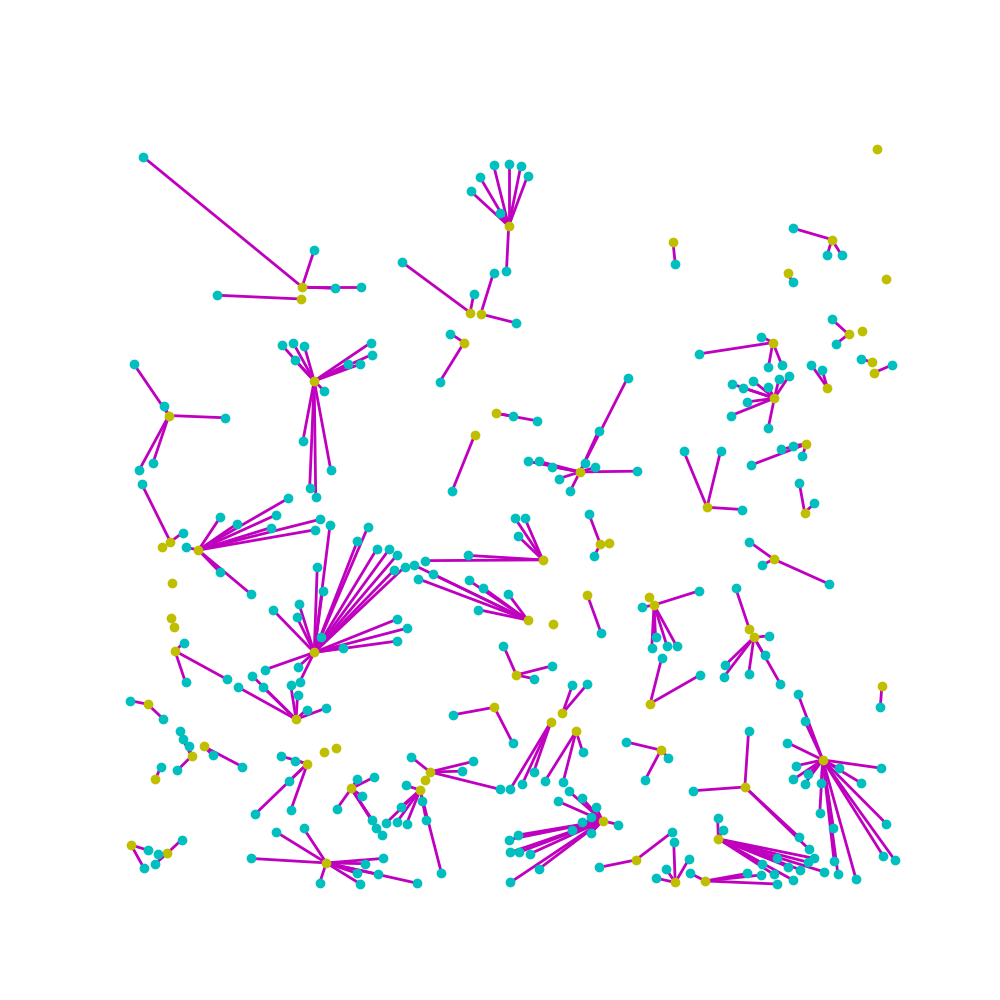

(0.0, 1024.0, 1024.0, 0.0)

In [15]:
cd4_coords = cell_scores.loc[cd4_pos, ['x_centroid', 'y_centroid']]
cd8_coords = cell_scores.loc[cd8_pos, ['x_centroid', 'y_centroid']]

tree = KDTree(cd8_coords)
dists, inds = tree.query(cd4_coords, k=1)

fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.plot([cd4_coords.get_values()[:, 0], cd8_coords.get_values()[np.squeeze(inds), 0]],
            [cd4_coords.get_values()[:, 1], cd8_coords.get_values()[np.squeeze(inds), 1]], c='m', linewidth=2)
ax.plot(cd8_coords['x_centroid'], cd8_coords['y_centroid'],
        '.', markersize=12, c='y')
ax.plot(cd4_coords['x_centroid'], cd4_coords['y_centroid'],
        '.', markersize=12, c='c')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, 1024])
ax.set_ylim([1024, 0])
ax.axis('off')

Finally, we can plot a histogram of the nearest neighbor distances calculated above to highlight the morphological distribution of, in this case, CD4+ and CD8+ cells.

<IPython.core.display.Javascript object>


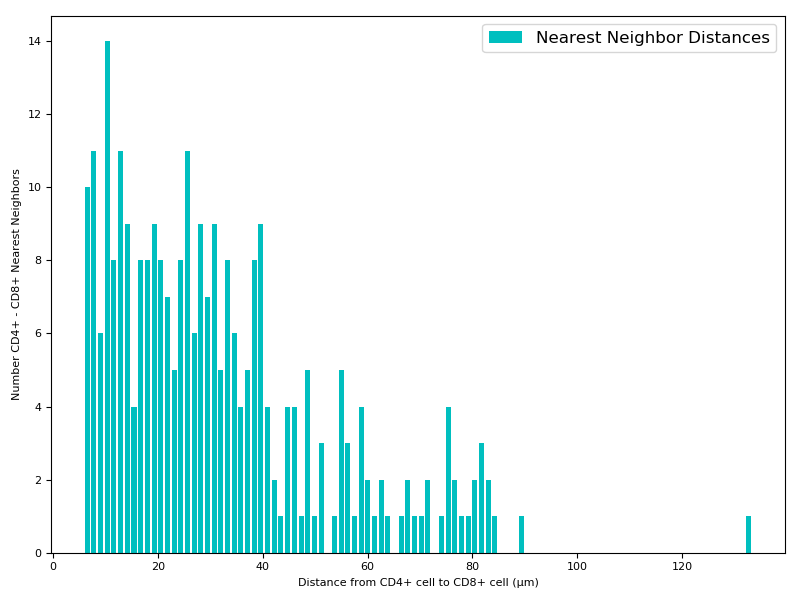

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Nearest neighbor distances were calculated in pixel units, so convert to microns.
um_per_pixel = 0.49
ax.hist(dists * um_per_pixel, bins=100, color='c', label='Nearest Neighbor Distances', rwidth=0.75)
ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel(u'Distance from CD4+ cell to CD8+ cell (\u03bcm)')
ax.set_ylabel('Number CD4+ - CD8+ Nearest Neighbors')
fig.tight_layout()